In [ ]:
#Sibi Marappan

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Baseline training
!unzip /content/drive/MyDrive/'Fall 2022'/CV/Project/class_data.zip

Archive:  /content/drive/MyDrive/Fall 2022/CV/Project/class_data.zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/training/
   creating: data/validation/
  inflating: data/training/.DS_Store  
  inflating: __MACOSX/data/training/._.DS_Store  
   creating: data/training/0/
   creating: data/training/1/
  inflating: data/validation/.DS_Store  
  inflating: __MACOSX/data/validation/._.DS_Store  
   creating: data/validation/0/
   creating: data/validation/1/
  inflating: data/training/0/19_149353_200586.tif  
  inflating: data/training/0/19_149353_200592.tif  
  inflating: data/training/0/19_149364_200592.tif  
  inflating: data/training/0/19_149364_200586.tif  
  inflating: data/training/0/19_149364_200579.tif  
  inflating: data/training/0/19_149358_200571.tif  
  inflating: data/training/0/19_149353_200579.tif  
  inflating: data/training/0/19_149356_200583.tif  
  inflating: data/training/0/19_149361_200583.tif  
 

In [ ]:
!find /content/data -name '.DS_Store' -type f -delete

In [ ]:
#MAE feature maps for training
!unzip /content/drive/MyDrive/'Fall 2022'/CV/Project/mae_prediction/mae_ft_train.zip

Archive:  /content/drive/MyDrive/Fall 2022/CV/Project/mae_prediction/mae_ft_train.zip
   creating: mae_ft_train/
  inflating: __MACOSX/._mae_ft_train  
   creating: mae_ft_train/mae_ft_train/
  inflating: __MACOSX/mae_ft_train/._mae_ft_train  
   creating: mae_ft_train/mae_ft_train/training/
  inflating: __MACOSX/mae_ft_train/mae_ft_train/._training  
   creating: mae_ft_train/mae_ft_train/label/
  inflating: __MACOSX/mae_ft_train/mae_ft_train/._label  
   creating: mae_ft_train/mae_ft_train/validation/
  inflating: __MACOSX/mae_ft_train/mae_ft_train/._validation  
   creating: mae_ft_train/mae_ft_train/training/0/
  inflating: __MACOSX/mae_ft_train/mae_ft_train/training/._0  
   creating: mae_ft_train/mae_ft_train/training/1/
  inflating: __MACOSX/mae_ft_train/mae_ft_train/training/._1  
  inflating: mae_ft_train/mae_ft_train/label/0train.txt  
  inflating: mae_ft_train/mae_ft_train/label/1train.txt  
  inflating: mae_ft_train/mae_ft_train/label/1val.txt  
  inflating: mae_ft_train/ma

In [ ]:
!find /content/mae_ft_train/mae_ft_train -name '.DS_Store' -type f -delete

In [ ]:
#Deformable DETR feature maps for trainingy

!unzip /content/drive/MyDrive/'Fall 2022'/CV/Project/detr_prediction/detr_ft_train.zip

Archive:  /content/drive/MyDrive/Fall 2022/CV/Project/detr_prediction/detr_ft_train.zip
replace __MACOSX/._detr_ft_train? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._detr_ft_train  
  inflating: detr_ft_train/.DS_Store  
replace __MACOSX/detr_ft_train/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/detr_ft_train/._.DS_Store  
  inflating: __MACOSX/detr_ft_train/._training  
  inflating: __MACOSX/detr_ft_train/._validation  
  inflating: detr_ft_train/training/.DS_Store  
  inflating: __MACOSX/detr_ft_train/training/._.DS_Store  
  inflating: __MACOSX/detr_ft_train/training/._0  
  inflating: __MACOSX/detr_ft_train/training/._1  
  inflating: detr_ft_train/validation/.DS_Store  
  inflating: __MACOSX/detr_ft_train/validation/._.DS_Store  
  inflating: __MACOSX/detr_ft_train/validation/._0  
  inflating: __MACOSX/detr_ft_train/validation/._1  
  inflating: detr_ft_train/training/0/19_149353_200586.tif  
  inflating: detr_ft_train/training/0/

In [ ]:
!find /content/detr_ft_train -name '.DS_Store' -type f -delete

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['training', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}
class_names = image_datasets['training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/mae_ft_train/mae_ft_train'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['training', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}
class_names = image_datasets['training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/detr_ft_train/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['training', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}
class_names = image_datasets['training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset_sizes

{'training': 539, 'validation': 247}

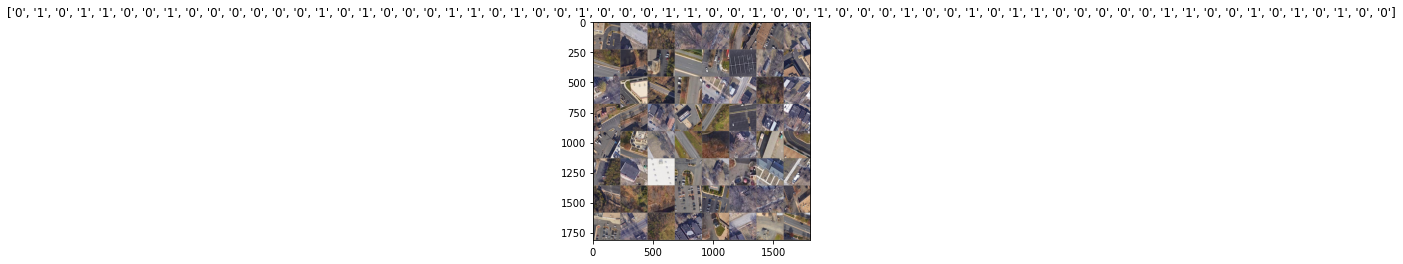

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        # self.layer3 = nn.Sequential(
        #     nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        
        
        # self.fc1 = nn.Linear(3*3*64,10)
        self.fc1 = nn.Linear(13*13*32,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        # out = self.layer3(out)
        # print(out.shape)
        out = out.view(out.size(0),-1)
        # print(out.shape)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Cnn().to(device)
model.train()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#baseline
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
training Loss: 0.6873 Acc: 0.5510
validation Loss: 0.6963 Acc: 0.4980

Epoch 1/14
----------
training Loss: 0.6551 Acc: 0.6438
validation Loss: 0.7095 Acc: 0.4737

Epoch 2/14
----------
training Loss: 0.6178 Acc: 0.6549
validation Loss: 0.7065 Acc: 0.4777

Epoch 3/14
----------
training Loss: 0.5879 Acc: 0.6772
validation Loss: 0.6533 Acc: 0.5344

Epoch 4/14
----------
training Loss: 0.5527 Acc: 0.7514
validation Loss: 0.5914 Acc: 0.6518

Epoch 5/14
----------
training Loss: 0.5015 Acc: 0.8089
validation Loss: 0.5422 Acc: 0.6883

Epoch 6/14
----------
training Loss: 0.4622 Acc: 0.8386
validation Loss: 0.4747 Acc: 0.7814

Epoch 7/14
----------
training Loss: 0.4424 Acc: 0.8646
validation Loss: 0.4667 Acc: 0.7976

Epoch 8/14
----------
training Loss: 0.4381 Acc: 0.8497
validation Loss: 0.4620 Acc: 0.7976

Epoch 9/14
----------
training Loss: 0.4165 Acc: 0.8924
validation Loss: 0.4612 Acc: 0.7976

Epoch 10/14
----------
training Loss: 0.4340 Acc: 0.8460
validation Lo

In [ ]:
#mae
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
training Loss: 0.7636 Acc: 0.3581
validation Loss: 0.6923 Acc: 0.5263

Epoch 1/14
----------
training Loss: 0.7120 Acc: 0.3878
validation Loss: 0.6920 Acc: 0.5263

Epoch 2/14
----------
training Loss: 0.7013 Acc: 0.4545
validation Loss: 0.6920 Acc: 0.5263

Epoch 3/14
----------
training Loss: 0.6759 Acc: 0.5918
validation Loss: 0.6917 Acc: 0.5263

Epoch 4/14
----------
training Loss: 0.6536 Acc: 0.6419
validation Loss: 0.6915 Acc: 0.5263

Epoch 5/14
----------
training Loss: 0.6305 Acc: 0.6531
validation Loss: 0.6918 Acc: 0.5263

Epoch 6/14
----------
training Loss: 0.6313 Acc: 0.6475
validation Loss: 0.6904 Acc: 0.5263

Epoch 7/14
----------
training Loss: 0.6198 Acc: 0.6494
validation Loss: 0.6864 Acc: 0.7652

Epoch 8/14
----------
training Loss: 0.6270 Acc: 0.6494
validation Loss: 0.6815 Acc: 0.4737

Epoch 9/14
----------
training Loss: 0.6153 Acc: 0.6494
validation Loss: 0.6785 Acc: 0.4737

Epoch 10/14
----------
training Loss: 0.6289 Acc: 0.6475
validation Lo

In [ ]:
#detr
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
training Loss: 0.6587 Acc: 0.6475
validation Loss: 0.6927 Acc: 0.5263

Epoch 1/19
----------
training Loss: 0.6624 Acc: 0.6494
validation Loss: 0.6926 Acc: 0.5263

Epoch 2/19
----------
training Loss: 0.6690 Acc: 0.6419
validation Loss: 0.6925 Acc: 0.5263

Epoch 3/19
----------
training Loss: 0.6674 Acc: 0.6456
validation Loss: 0.6929 Acc: 0.5911

Epoch 4/19
----------
training Loss: 0.6533 Acc: 0.6494
validation Loss: 0.6940 Acc: 0.4737

Epoch 5/19
----------
training Loss: 0.6503 Acc: 0.6494
validation Loss: 0.6958 Acc: 0.4737

Epoch 6/19
----------
training Loss: 0.6579 Acc: 0.6438
validation Loss: 0.6975 Acc: 0.4737

Epoch 7/19
----------
training Loss: 0.6617 Acc: 0.6456
validation Loss: 0.6986 Acc: 0.4737

Epoch 8/19
----------
training Loss: 0.6510 Acc: 0.6475
validation Loss: 0.7000 Acc: 0.4737

Epoch 9/19
----------
training Loss: 0.6516 Acc: 0.6512
validation Loss: 0.7020 Acc: 0.4737

Epoch 10/19
----------
training Loss: 0.6576 Acc: 0.6419
validation Lo

#### Predictions

In [ ]:
!unzip /content/drive/MyDrive/'Fall 2022'/CV/Project/test.zip

Archive:  /content/drive/MyDrive/Fall 2022/CV/Project/test.zip
   creating: test/
  inflating: test/.DS_Store          
  inflating: __MACOSX/test/._.DS_Store  
   creating: test/0/
   creating: test/1/
  inflating: test/0/19_132292_212356.tif  
  inflating: test/0/19_132291_212358.tif  
  inflating: test/0/.DS_Store        
  inflating: __MACOSX/test/0/._.DS_Store  
  inflating: test/0/19_132291_212359.tif  
  inflating: test/0/19_132292_212357.tif  
  inflating: test/0/19_132292_212355.tif  
  inflating: test/0/19_132292_212354.tif  
  inflating: test/0/19_132289_212355.tif  
  inflating: test/0/19_132289_212354.tif  
  inflating: test/0/19_132289_212356.tif  
  inflating: test/0/19_132289_212357.tif  
  inflating: test/0/19_132293_212359.tif  
  inflating: test/0/19_132290_212357.tif  
  inflating: test/0/19_132290_212356.tif  
  inflating: test/0/19_132293_212358.tif  
  inflating: test/0/19_132290_212354.tif  
  inflating: test/0/19_132290_212355.tif  
  inflating: test/0/19_13229

In [ ]:
!find /content/test/ -name '.DS_Store' -type f -delete

In [ ]:
def data_process(input):

  preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])

  input_preprocessed = preprocess(input)

  batch_img_tensor = torch.unsqueeze(input_preprocessed, 0)
  batch_img_tensor = batch_img_tensor.to(device)
  return batch_img_tensor

In [ ]:
def predict(input):
  model.eval()
  out = model(input)
  res = out.argmax().data.tolist()
  return res

In [ ]:
#test original

from PIL import Image
import os
from sklearn.metrics import classification_report

predicted_labels = []
original_labels = []

#Class 0

for file_name in os.listdir('/content/test/0/'):
  img = Image.open('/content/test/0/' + file_name).convert('RGB')
  batch_img_tensor = data_process(img)
  cls = predict(batch_img_tensor)
  predicted_labels.append(cls)
  original_labels.append(0)

#Class 1

for file_name in os.listdir('/content/test/1/'):
  img = Image.open('/content/test/1/' + file_name).convert('RGB')
  batch_img_tensor = data_process(img)
  cls = predict(batch_img_tensor)
  predicted_labels.append(cls)
  original_labels.append(1)

print(classification_report(original_labels, predicted_labels, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.40      0.63      0.49        30
           1       0.42      0.22      0.29        36

    accuracy                           0.41        66
   macro avg       0.41      0.43      0.39        66
weighted avg       0.41      0.41      0.38        66



In [ ]:
#mae feature maps

from PIL import Image
import os
from sklearn.metrics import classification_report

predicted_labels = []
original_labels = []

#Class 0

for file_name in os.listdir('/content/drive/MyDrive/Fall 2022/CV/Project/mae_prediction/prediction_result/feature_maps/0fm/'):
  img = Image.open('/content/drive/MyDrive/Fall 2022/CV/Project/mae_prediction/prediction_result/feature_maps/0fm/' + file_name).convert('RGB')
  batch_img_tensor = data_process(img)
  cls = predict(batch_img_tensor)
  predicted_labels.append(cls)
  original_labels.append(0)

#Class 1

for file_name in os.listdir('/content/drive/MyDrive/Fall 2022/CV/Project/mae_prediction/prediction_result/feature_maps/1fm/'):
  img = Image.open('/content/drive/MyDrive/Fall 2022/CV/Project/mae_prediction/prediction_result/feature_maps/1fm/' + file_name).convert('RGB')
  batch_img_tensor = data_process(img)
  cls = predict(batch_img_tensor)
  predicted_labels.append(cls)
  original_labels.append(1)

print(classification_report(original_labels, predicted_labels, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.33      0.53      0.41        30
           1       0.18      0.08      0.11        36

    accuracy                           0.29        66
   macro avg       0.25      0.31      0.26        66
weighted avg       0.24      0.29      0.25        66



In [ ]:
#detr feature maps

from PIL import Image
import os
from sklearn.metrics import classification_report

predicted_labels = []
original_labels = []

#Class 0

for file_name in os.listdir('/content/drive/MyDrive/Fall 2022/CV/Project/detr_prediction/prediction_results/feature_maps/0fm'):
  img = Image.open('/content/drive/MyDrive/Fall 2022/CV/Project/detr_prediction/prediction_results/feature_maps/0fm/' + file_name).convert('RGB')
  batch_img_tensor = data_process(img)
  cls = predict(batch_img_tensor)
  predicted_labels.append(cls)
  original_labels.append(0)

#Class 1

for file_name in os.listdir('/content/drive/MyDrive/Fall 2022/CV/Project/detr_prediction/prediction_results/feature_maps/1fm'):
  img = Image.open('/content/drive/MyDrive/Fall 2022/CV/Project/detr_prediction/prediction_results/feature_maps/1fm/' + file_name).convert('RGB')
  batch_img_tensor = data_process(img)
  cls = predict(batch_img_tensor)
  predicted_labels.append(cls)
  original_labels.append(1)

print(classification_report(original_labels, predicted_labels, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.24      0.13      0.17        30
           1       0.47      0.64      0.54        36

    accuracy                           0.41        66
   macro avg       0.35      0.39      0.36        66
weighted avg       0.36      0.41      0.37        66



#### Discussion

In [ ]:
class_names = {
'plane': 0,
'ship': 1,
'storage-tank': 2,
'baseball-diamond': 3,
'tennis-court': 4,
'basketball-court': 5,
'ground-track-field': 6,
'harbor': 7,
'bridge': 8,
'large-vehicle': 9,
'small-vehicle': 10,
'helicopter': 11,
'roundabout': 12,
'soccer-ball-field': 13,
'swimming-pool': 14,
'container-crane': 15
}

In [ ]:
def get_key(val):
  for key, value in class_names.items():
    if val == value:
      return key

In [ ]:
#MAE class 0

import re
import os
class_dict =  {x:0 for x in range(1, 17)}

f = open('/content/drive/MyDrive/Fall 2022/CV/Project/mae_prediction/prediction_result/labels/0lbl.txt', 'r')
lines = f.readlines()

for line in lines:
  classes = re.findall(r'\b\d+\b', line)
  for val in classes:
    class_dict[int(val)]+=1

pred_res = class_dict.copy()
for key in class_dict.keys():
  name = get_key(key-1)
  pred_res[name] = class_dict[key]
  del pred_res[key]

pred_res

{'plane': 357,
 'ship': 0,
 'storage-tank': 0,
 'baseball-diamond': 352,
 'tennis-court': 0,
 'basketball-court': 0,
 'ground-track-field': 11,
 'harbor': 0,
 'bridge': 948,
 'large-vehicle': 1332,
 'small-vehicle': 0,
 'helicopter': 0,
 'roundabout': 0,
 'soccer-ball-field': 0,
 'swimming-pool': 0,
 'container-crane': 0}

In [ ]:
#MAE class 1

class_dict =  {x:0 for x in range(1, 17)}

f = open('/content/drive/MyDrive/Fall 2022/CV/Project/mae_prediction/prediction_result/labels/1lbl.txt', 'r')
lines = f.readlines()

for line in lines:
  classes = re.findall(r'\b\d+\b', line)
  for val in classes:
    class_dict[int(val)]+=1

pred_res = class_dict.copy()
for key in class_dict.keys():
  name = get_key(key-1)
  pred_res[name] = class_dict[key]
  del pred_res[key]

pred_res

{'plane': 163,
 'ship': 0,
 'storage-tank': 0,
 'baseball-diamond': 909,
 'tennis-court': 0,
 'basketball-court': 0,
 'ground-track-field': 46,
 'harbor': 0,
 'bridge': 618,
 'large-vehicle': 1864,
 'small-vehicle': 0,
 'helicopter': 0,
 'roundabout': 0,
 'soccer-ball-field': 0,
 'swimming-pool': 0,
 'container-crane': 0}

In [ ]:
#DETR class 0

class_dict =  {x:0 for x in range(0, 16)}

f = open('/content/drive/MyDrive/Fall 2022/CV/Project/detr_prediction/prediction_results/labels/0lbl.txt', 'r')
lines = f.readlines()

for line in lines:
  classes = re.findall(r'\b\d+\b', line)
  for val in classes:
    class_dict[int(val)]+=1

pred_res = class_dict.copy()
for key in class_dict.keys():
  name = get_key(key)
  pred_res[name] = class_dict[key]
  del pred_res[key]

pred_res

{'plane': 31,
 'ship': 3,
 'storage-tank': 52,
 'baseball-diamond': 18,
 'tennis-court': 407,
 'basketball-court': 55,
 'ground-track-field': 8,
 'harbor': 3,
 'bridge': 0,
 'large-vehicle': 214,
 'small-vehicle': 8135,
 'helicopter': 0,
 'roundabout': 0,
 'soccer-ball-field': 72,
 'swimming-pool': 2,
 'container-crane': 0}

In [ ]:
#DETR class 1

class_dict =  {x:0 for x in range(0, 16)}

f = open('/content/drive/MyDrive/Fall 2022/CV/Project/detr_prediction/prediction_results/labels/1lbl.txt', 'r')
lines = f.readlines()

for line in lines:
  classes = re.findall(r'\b\d+\b', line)
  for val in classes:
    class_dict[int(val)]+=1

pred_res = class_dict.copy()
for key in class_dict.keys():
  name = get_key(key)
  pred_res[name] = class_dict[key]
  del pred_res[key]

pred_res

{'plane': 215,
 'ship': 2,
 'storage-tank': 67,
 'baseball-diamond': 62,
 'tennis-court': 606,
 'basketball-court': 208,
 'ground-track-field': 10,
 'harbor': 29,
 'bridge': 13,
 'large-vehicle': 543,
 'small-vehicle': 8883,
 'helicopter': 0,
 'roundabout': 2,
 'soccer-ball-field': 160,
 'swimming-pool': 0,
 'container-crane': 0}